    Roman Peerboom  10791523
    Floris de Vries 11710799

In [1]:
import numpy
import simpy
import random
import statistics 
import time
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
## First in first out system 

def source(env, number, lambda_1, counter, mu):
    """Source generates customers randomly"""
    for i in range(number):
        c = object(env, 'Customer%02d' % i, counter, mu)
        env.process(c)
        t = random.expovariate(lambda_1)     # Time before new customer arrives
        yield env.timeout(t)
        
        
def object(env, name, counter, mu):
    """Customer arrives, is served and leaves."""
    arrive = env.now
#     print('%7.4f %s: Here I am' % (arrive, name))
    with counter.request() as req:
        results = yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        # We got to the counter
#         print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        tib = random.expovariate(mu)
        yield env.timeout(tib)
#         print('%7.4f %s: Finished' % (env.now, name))

In [3]:
n_s = [1, 2, 4]                              # Number of servers
simulations = 100
mean_waiting_times = [[],[],[]]

start_time = time.time()

for n_ind in range(len(n_s)):
    n = n_s[n_ind]
    lambda_1 = arrival_rate = n/15              # Arrival rate, n/(inter arrival time)
    time_in_system = 14                        # Mean time in system 
    mu = 1/time_in_system                      # How much people one server can help for a given time period 
    number_of_arrivals = 10000000000
    print("\N{greek small letter rho} is: " + str(lambda_1/(n*mu)) + " with lambda: " +
          str(lambda_1) + " & mu: " + str(mu) +  " for " + str(n) + " server(s).")
    for simulation in range(simulations):
#         print("Simulation: " + str(simulation))
        waiting_times = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=n) 
        env.process(source(env,number_of_arrivals,lambda_1, server, mu))
        env.run(until=1000000)
#         print("Average waiting time for this simulation: " + str(statistics.mean(waiting_times)))
        mean_waiting_times[n_ind].append(statistics.mean(waiting_times))    
    print("Average waiting time: " + str(statistics.mean(mean_waiting_times[n_ind])) +
          " with sd: " + str(statistics.stdev(mean_waiting_times[n_ind])) + "\n")
    
end_time = time.time()
print("Running time: " + str(end_time - start_time))

ρ is: 0.9333333333333333 with lambda: 0.06666666666666667 & mu: 0.07142857142857142 for 1 server(s).
Average waiting time: 192.617253879132 with sd: 20.761102524103137

ρ is: 0.9333333333333333 with lambda: 0.13333333333333333 & mu: 0.07142857142857142 for 2 server(s).
Average waiting time: 92.60534837546952 with sd: 7.8554549095523605

ρ is: 0.9333333333333333 with lambda: 0.26666666666666666 & mu: 0.07142857142857142 for 4 server(s).
Average waiting time: 44.832678035345495 with sd: 3.017963959831067

Running time: 1628.4171295166016


In [4]:
statistic_1server = scipy.stats.shapiro(mean_waiting_times[0])
print(statistic_1server)
statistic_2server = scipy.stats.shapiro(mean_waiting_times[1])
print(statistic_2server)
statistic_3server = scipy.stats.shapiro(mean_waiting_times[2])
print(statistic_3server)

print(scipy.stats.mannwhitneyu(mean_waiting_times[0], mean_waiting_times[1]))
print(scipy.stats.mannwhitneyu(mean_waiting_times[1], mean_waiting_times[2]))

ShapiroResult(statistic=0.972661554813385, pvalue=0.03545880690217018)
ShapiroResult(statistic=0.9435343146324158, pvalue=0.0003188191039953381)
ShapiroResult(statistic=0.9563524723052979, pvalue=0.002228413475677371)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)


C:\Users\flori\anaconda3\lib\site-packages\seaborn\axisgrid.py:923: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, **kwargs)


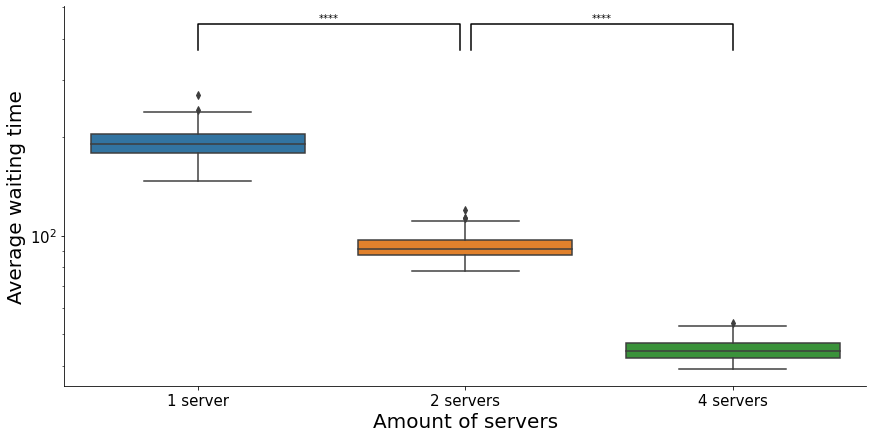

In [5]:
## Plotting the results as boxplots for different methods
df_1_server = pd.DataFrame({'Waiting time': mean_waiting_times[0], 'Method': ['1 server' for i in range(len(mean_waiting_times[0]))], 'service_distr': ['Memoryless' for i in range(len(mean_waiting_times[0]))]})
df_2_server = pd.DataFrame({'Waiting time': mean_waiting_times[1], 'Method': ['2 servers' for i in range(len(mean_waiting_times[1]))], 'service_distr': ['Memoryless' for i in range(len(mean_waiting_times[0]))]})
df_3_server = pd.DataFrame({'Waiting time': mean_waiting_times[2], 'Method': ['4 servers' for i in range(len(mean_waiting_times[2]))], 'service_distr': ['Memoryless' for i in range(len(mean_waiting_times[0]))]})
df_total = df_1_server.append(df_2_server)
df_total = df_total.append(df_3_server)

p = sns.catplot(x="Method", y="Waiting time", kind="box", data=df_total, height=6, aspect=12/6)

plt.xlabel("Amount of servers", size = 20)
plt.ylabel("Average waiting time", size = 20)
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
p.set_yticklabels(ylabels, size=15)
p.set_xticklabels(xlabels, size=15)
p.set(yscale="log")

x1, x2 = 0, 0.98   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = df_total['Waiting time'].max() + 100, 75, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

x3, x4 = 1.02, 2   # columns '2 server' and '4 server' (first column: 0, see plt.xticks())
y1, h1, col = df_total['Waiting time'].max() + 100, 75, 'k'
# y1, h1, col = 1, 0.25, 'k'
plt.plot([x3, x3, x4, x4], [y1, y1+h1, y1+h1, y1], lw=1.5, c=col)
plt.text((x3+x4)*.5, y1+h1, "****", ha='center', va='bottom', color=col)

plt.savefig('boxplots_server_amount.png', format='png', dpi=600, bbox_inches = "tight")


## FIFO versus priority ot the smallest job for 1 server

In [6]:
## Give priority to the smallest job

def source_prior(env, number, lambda_1, counter, mu):
    """Source generates customers randomly"""
    for i in range(number):
        c = object_prior(env, 'Customer%02d' % i, counter, mu)
        env.process(c)
        t = random.expovariate(lambda_1)
        yield env.timeout(t)
        
        
def object_prior(env, name, counter, mu):
    """Customer arrives, is served and leaves."""
    arrive = env.now
#     print('%7.4f %s: Here I am' % (arrive, name))
    tib = random.expovariate(mu)
    with counter.request(priority = tib) as req:
        results = yield req
        wait = env.now - arrive
        waiting_times_priority.append(wait)
        # We got to the counter
#         print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

        yield env.timeout(tib)
#         print('%7.4f %s: Finished' % (env.now, name))

In [7]:
start_time = time.time()

n = 1                                       # Number of servers
lambda_1 = arrival_rate = n/15              # Arrival rate, events in given time period
time_in_system = 14                         # Mean time in system 
mu = 1/time_in_system                      # How much people one server can help for a given time period 
simulations = 100
number_of_arrivals = 10000000000
print("\N{greek small letter rho} is: " + str(lambda_1/(n*mu)) + " with lambda: " +
      str(lambda_1) + " & mu: " + str(mu) +  " for " + str(n) + " server(s).")

mean_waiting_times_priority = []
for simulation in range(simulations):
#         print("Simulation: " + str(simulation))
    waiting_times_priority = []
    env = simpy.Environment()
    server = simpy.PriorityResource(env, capacity=n) 
    env.process(source_prior(env,number_of_arrivals,lambda_1, server, mu))
    env.run(until=1000000)
    mean_waiting_times_priority.append(statistics.mean(waiting_times_priority))    
print("Average waiting time: " + str(statistics.mean(mean_waiting_times_priority)) +
      " with sd: " + str(statistics.stdev(mean_waiting_times_priority)) + "\n")
    
end_time = time.time()
print("Running time: " + str(end_time - start_time))

ρ is: 0.9333333333333333 with lambda: 0.06666666666666667 & mu: 0.07142857142857142 for 1 server(s).
Average waiting time: 59.8179147109432 with sd: 4.823470690664082

Running time: 246.91836643218994


In [8]:
statistic_1server_FIFO = scipy.stats.shapiro(mean_waiting_times[0])
print(statistic_1server)
statistic_1server_prior = scipy.stats.shapiro(mean_waiting_times_priority)
print(statistic_1server_prior)

print(scipy.stats.mannwhitneyu(mean_waiting_times[0], mean_waiting_times_priority))

ShapiroResult(statistic=0.972661554813385, pvalue=0.03545880690217018)
ShapiroResult(statistic=0.9738414287567139, pvalue=0.04380549117922783)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)


C:\Users\flori\anaconda3\lib\site-packages\seaborn\axisgrid.py:923: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, **kwargs)


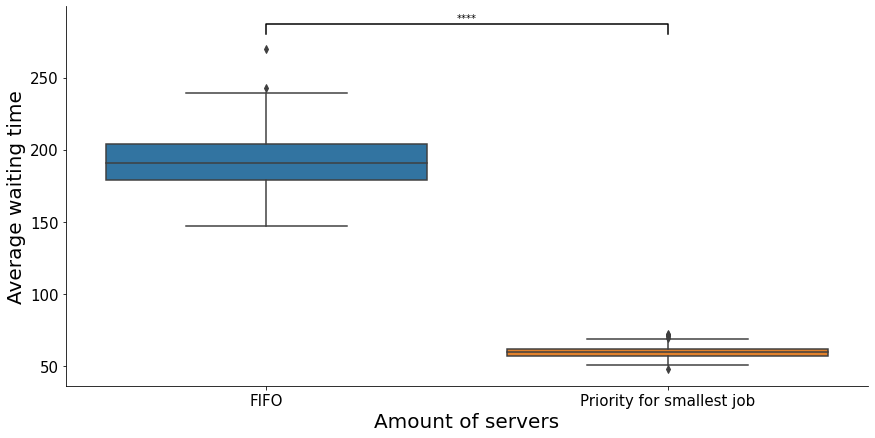

In [9]:
df_1_server_LOFF = pd.DataFrame({'Waiting time': mean_waiting_times[0], 'Method': ['FIFO' for i in range(len(mean_waiting_times[0]))]})
df_1_server_prior = pd.DataFrame({'Waiting time': mean_waiting_times_priority, 'Method': ['Priority for smallest job' for i in range(len(mean_waiting_times_priority))]})
df_total_1_server = df_1_server_LOFF.append(df_1_server_prior)

p = sns.catplot(x="Method", y="Waiting time", kind="box", data=df_total_1_server, height=6, aspect=12/6)

plt.xlabel("Amount of servers", size = 20)
plt.ylabel("Average waiting time", size = 20)
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
p.set_yticklabels(ylabels, size=15)
p.set_xticklabels(xlabels, size=15)
# p.set(yscale="log")

x1, x2 = 0, 1   # columns 'LOFF' and 'Priority' (first column: 0, see plt.xticks())
y, h, col = df_total['Waiting time'].max() + 10, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

plt.savefig('boxplots_1server_LOFF_priority.png', format='png', dpi=600, bbox_inches = "tight")


## Different service rate distribution times

### M/D/1 vs M/D/n queues

In [10]:
## First in first out system 
def sourcec(env, number, lambda_1, counter, mu):
    """Source generates customers randomly"""
    for i in range(number):
        c = objectc(env, 'Customer%02d' % i, counter, mu)
        env.process(c)
        t = random.expovariate(lambda_1)     # Time before new customer arrives
        yield env.timeout(t)
        
        
def objectc(env, name, counter, mu):
    """Customer arrives, is served and leaves."""
    arrive = env.now
#     print('%7.4f %s: Here I am' % (arrive, name))
    with counter.request() as req:
        results = yield req
        wait = env.now - arrive
        waiting_timesc.append(wait)
        # We got to the counter
#         print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        tib = 1/mu
        yield env.timeout(tib)
#         print('%7.4f %s: Finished' % (env.now, name))

In [11]:
n_s = [1, 2, 4]                              # Number of servers
simulations = 100
mean_waiting_timesc = [[],[],[]]

start_time = time.time()

for n_ind in range(len(n_s)):
    n = n_s[n_ind]
    lambda_1 = arrival_rate = n/15              # Arrival rate, n/(inter arrival time)
    time_in_system = 14                        # Mean time in system 
    mu = 1/time_in_system                      # How much people one server can help for a given time period 
    number_of_arrivals = 10000000000
    print("\N{greek small letter rho} is: " + str(lambda_1/(n*mu)) + " with lambda: " +
          str(lambda_1) + " & mu: " + str(mu) +  " for " + str(n) + " server(s).")
    for simulation in range(simulations):
#         print("Simulation: " + str(simulation))
        waiting_timesc = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=n) 
        env.process(sourcec(env,number_of_arrivals,lambda_1, server, mu))
        env.run(until=1000000)
#         print("Average waiting time for this simulation: " + str(statistics.mean(waiting_times)))
        mean_waiting_timesc[n_ind].append(statistics.mean(waiting_timesc))    
    print("Average waiting time: " + str(statistics.mean(mean_waiting_timesc[n_ind])) +
          " with sd: " + str(statistics.stdev(mean_waiting_timesc[n_ind])) + "\n")
    
end_time = time.time()
print("Running time: " + str(end_time - start_time))

ρ is: 0.9333333333333333 with lambda: 0.06666666666666667 & mu: 0.07142857142857142 for 1 server(s).
Average waiting time: 98.14129374672586 with sd: 7.766786213017732

ρ is: 0.9333333333333333 with lambda: 0.13333333333333333 & mu: 0.07142857142857142 for 2 server(s).
Average waiting time: 47.685370611115026 with sd: 3.13703535636847

ρ is: 0.9333333333333333 with lambda: 0.26666666666666666 & mu: 0.07142857142857142 for 4 server(s).
Average waiting time: 22.8874596940379 with sd: 1.1241256847216075

Running time: 1436.3065376281738


In [16]:
statistic_1serverc = scipy.stats.shapiro(mean_waiting_timesc[0])
print(statistic_1serverc)
statistic_2serverc = scipy.stats.shapiro(mean_waiting_timesc[1])
print(statistic_2serverc)
statistic_3serverc = scipy.stats.shapiro(mean_waiting_timesc[2])
print(statistic_3serverc)

print(scipy.stats.mannwhitneyu(mean_waiting_timesc[0], mean_waiting_times[0]))
print(scipy.stats.mannwhitneyu(mean_waiting_timesc[1], mean_waiting_times[1]))
print(scipy.stats.mannwhitneyu(mean_waiting_timesc[2], mean_waiting_times[2]))

ShapiroResult(statistic=0.9247168898582458, pvalue=2.5268125682487153e-05)
ShapiroResult(statistic=0.9891124367713928, pvalue=0.5934351086616516)
ShapiroResult(statistic=0.9628115892410278, pvalue=0.006412259303033352)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)


C:\Users\flori\anaconda3\lib\site-packages\seaborn\axisgrid.py:923: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, **kwargs)


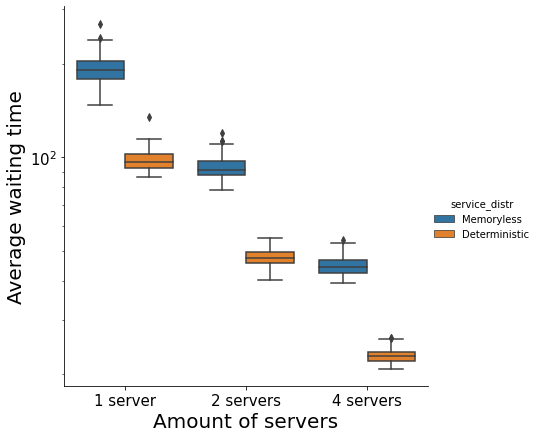

In [15]:
df_1_serverc = pd.DataFrame({'Waiting time': mean_waiting_timesc[0], 'Method': ['1 server' for i in range(len(mean_waiting_timesc[0]))], 'service_distr': ['Deterministic' for i in range(len(mean_waiting_timesc[0]))]})
df_2_serverc = pd.DataFrame({'Waiting time': mean_waiting_timesc[1], 'Method': ['2 servers' for i in range(len(mean_waiting_timesc[1]))], 'service_distr': ['Deterministic' for i in range(len(mean_waiting_timesc[0]))]})
df_3_serverc = pd.DataFrame({'Waiting time': mean_waiting_timesc[2], 'Method': ['4 servers' for i in range(len(mean_waiting_timesc[2]))], 'service_distr': ['Deterministic' for i in range(len(mean_waiting_timesc[0]))]})


df_totalc = df_total.append(df_1_serverc)
df_totalc = df_totalc.append(df_2_serverc)
df_totalc = df_totalc.append(df_3_serverc)


p = sns.catplot(x="Method", y="Waiting time", hue = 'service_distr', kind="box", data=df_totalc, height=6, aspect=8/8)
# p = sns.swarmplot(x="Method", y="Waiting time", hue = 'service_distr', data=df_totalc, alpha = 0.5)

plt.xlabel("Amount of servers", size = 20)
plt.ylabel("Average waiting time", size = 20)
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
p.set_yticklabels(ylabels, size=15)
p.set_xticklabels(xlabels, size=15)
p.set(yscale="log")

# x1, x2 = 0, 0.98   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
# y, h, col = df_total['Waiting time'].max() + 100, 75, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

# x3, x4 = 1.02, 2   # columns '2 server' and '4 server' (first column: 0, see plt.xticks())
# y1, h1, col = df_total['Waiting time'].max() + 100, 75, 'k'
# # y1, h1, col = 1, 0.25, 'k'
# plt.plot([x3, x3, x4, x4], [y1, y1+h1, y1+h1, y1], lw=1.5, c=col)
# plt.text((x3+x4)*.5, y1+h1, "****", ha='center', va='bottom', color=col)

plt.savefig('boxplots_service_distr.png', format='png', dpi=600, bbox_inches = "tight")


### Longtail distribution

In [13]:
def source_long(env, number, lambda_1, counter, mu):
    """Source generates customers randomly"""
    for i in range(number):
        c = object_long(env, 'Customer%02d' % i, counter, mu)
        env.process(c)
        t = random.expovariate(lambda_1)     # Time before new customer arrives
        yield env.timeout(t)
        
        
def object_long(env, name, counter, mu):
    """Customer arrives, is served and leaves."""
    arrive = env.now
#     print('%7.4f %s: Here I am' % (arrive, name))
    with counter.request() as req:
        results = yield req
        wait = env.now - arrive
        waiting_times_long.append(wait)
        # We got to the counter
#         print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        rand_serv = random.random()
        if rand_serv < 0.75:
            tib = random.expovariate(mu[0])
        else:
            tib = random.expovariate(mu[1])
        yield env.timeout(tib)
#         print('%7.4f %s: Finished' % (env.now, name))

In [14]:
n_s = [1, 2, 4]                              # Number of servers
simulations = 100
mean_waiting_times_long = [[],[],[]]

start_time = time.time()

for n_ind in range(len(n_s)):
    n = n_s[n_ind]
    lambda_1 = arrival_rate = n/15              # Arrival rate, n/(inter arrival time)
    mu = [1/4, 1/(52/17)]                     # How much people one server can help for a given time period 
    number_of_arrivals = 10000000000
    print("\N{greek small letter rho} is: " + str(lambda_1/(n*(1/14))) + " with lambda: " +
          str(lambda_1) + " & mu: " + str(1/14) +  " for " + str(n) + " server(s).")
    for simulation in range(simulations):
#         print("Simulation: " + str(simulation))
        waiting_times_long = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=n) 
        env.process(source_long(env,number_of_arrivals,lambda_1, server, mu))
        env.run(until=1000000)
        mean_waiting_times_long[n_ind].append(statistics.mean(waiting_times_long)) 
    print("Average waiting time: " + str(statistics.mean(mean_waiting_times_long[n_ind])) +
          " with sd: " + str(statistics.stdev(mean_waiting_times_long[n_ind])) + "\n")
    
end_time = time.time()
print("Running time: " + str(end_time - start_time))

ρ is: 0.9333333333333333 with lambda: 0.06666666666666667 & mu: 0.07142857142857142 for 1 server(s).
Average waiting time: 1.276949105922774 with sd: 0.02194267962709785

ρ is: 0.9333333333333333 with lambda: 0.13333333333333333 & mu: 0.07142857142857142 for 2 server(s).
Average waiting time: 0.25417752001911226 with sd: 0.005710768924831285

ρ is: 0.9333333333333333 with lambda: 0.26666666666666666 & mu: 0.07142857142857142 for 4 server(s).
Average waiting time: 0.02627590028086383 with sd: 0.0008872738380534312

Running time: 1753.0136904716492
